Performing inference on: /content/syndata_mito/test/images/synthetic_mito_em_1.png


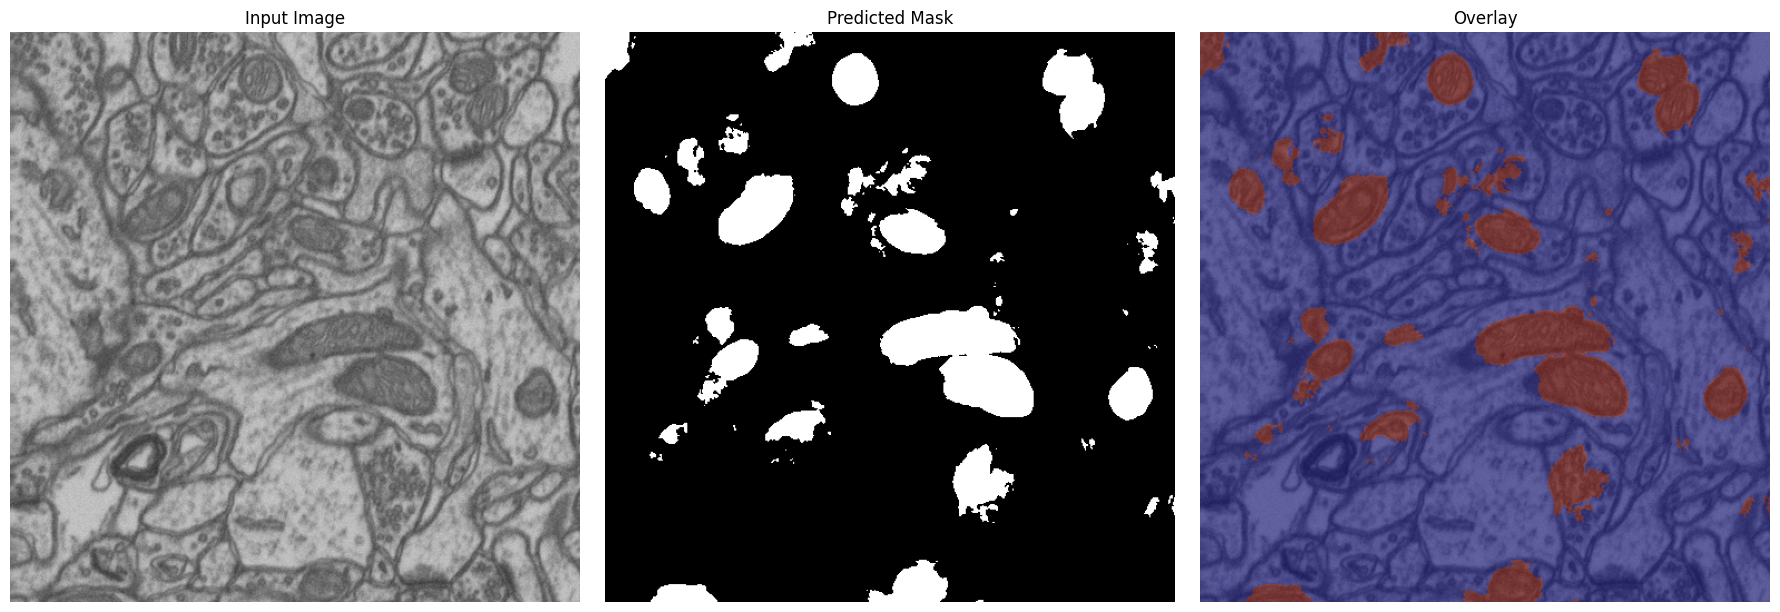

In [50]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the input image for inference (replace with your image path)
infer_input = '/content/syndata_mito/test/images/synthetic_mito_em_1.png'  # Example: use one of the test images

# Define the same transformations used for validation/testing
inference_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Load the best model from the 'pth' folder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None, # Weights are loaded from saved checkpoint, not imagenet here
    in_channels=3,
    classes=1,
    activation=None,
).to(device)

# Check for best_model.pth first, then the complete model
model_path = 'pth/best_model.pth'
if not os.path.exists(model_path):
    model_path = 'pth/mitochondria_em_binary_seg_unet_model_complete.pth'
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        raise FileNotFoundError(f"No model found at {model_path} or pth/best_model.pth")
else:
    model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

def predict_and_visualize(image_path, model, transform, device):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image_display = image.copy() # For displaying original image without normalization

    # Apply transformations
    augmented = transform(image=image)
    input_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output)
        predicted_mask = (pred_prob > 0.5).squeeze().cpu().numpy().astype(np.uint8)

    # Convert original image for display (denormalize if necessary for overlay)
    # The 'image' variable passed to transform is already RGB, but we need the raw one for display
    # The input_tensor is normalized, but we want to show the original input visually.
    # Since the input to the transform was 'image', let's use the copy we made.

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_image_display)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    axes[2].imshow(original_image_display)
    axes[2].imshow(predicted_mask, cmap='jet', alpha=0.5) # Overlay with a colormap
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

print(f"Performing inference on: {infer_input}")
predict_and_visualize(infer_input, model, inference_transform, device)
